In [1]:
import numpy as np

from nncore import nn
from nncore.nn import optim
from nncore.utils import chunks, sigmoid, tiles, randn, zeros, ones

np.random.seed(42)

Load MNIST dataset

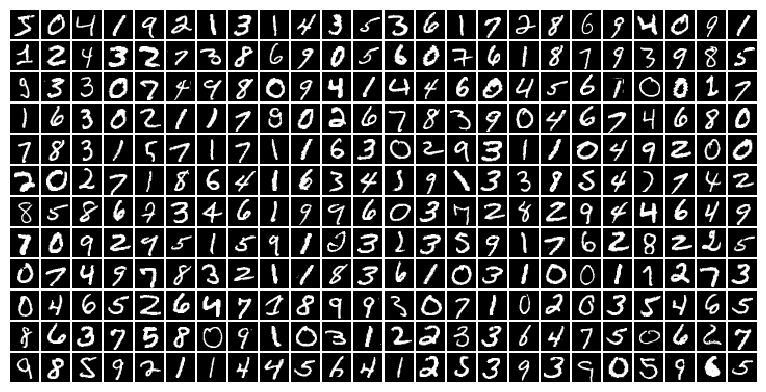

In [2]:
from mnists import MNIST

mnist = MNIST()
digits = mnist.train_images()
digits = digits[: 12 * 24]
digits = digits.reshape(-1, 24, 28, 28)
tiles(digits)

In [3]:
# Training set
X_train = mnist.train_images().astype(np.float32) / 255.0
X_train = X_train.reshape(-1, 28 * 28)
np.random.shuffle(X_train)

size = 60_000
X_train = X_train[:size, ...]

Define generator and discriminator

In [4]:
latent_dim = 64

G = nn.Sequential(
    nn.Linear(vsize=latent_dim, hsize=128, init_method="He"),
    nn.ReLU(),
    nn.Linear(vsize=128, hsize=256, init_method="He"),
    nn.ReLU(),
    nn.Linear(vsize=256, hsize=512, init_method="He"),
    nn.ReLU(),
    nn.Linear(vsize=512, hsize=784, init_method="He"),
    nn.Sigmoid(),
)

D = nn.Sequential(
    nn.Linear(vsize=784, hsize=512, init_method="He"),
    nn.ReLU(),
    nn.Linear(vsize=512, hsize=512, init_method="He"),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(vsize=512, hsize=1, init_method="He"),
)

Check if generator works

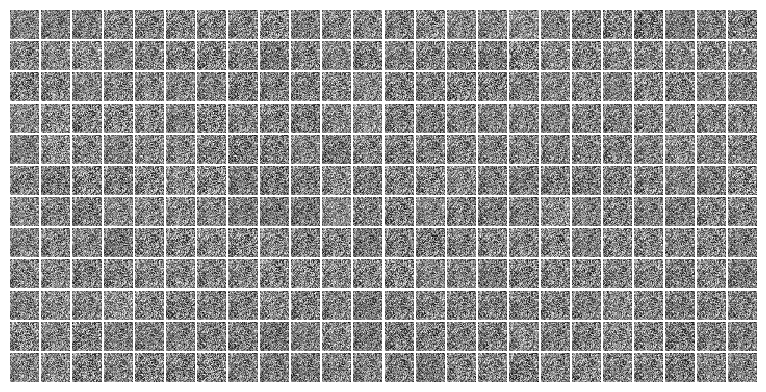

In [5]:
fixed_noise = randn(12 * 24, latent_dim)
samples = G.forward(fixed_noise, training=False)
samples = samples.reshape(12, 24, 28, 28)
tiles(samples)

Define loss function

In [6]:
from numpy.typing import NDArray


def cross_entropy(targets: NDArray, logits: NDArray, eps: float = 1e-8) -> float:
    batch_size = targets.shape[0]
    σ = sigmoid(logits)
    return -1 / batch_size * np.sum(targets * np.log(σ + eps) + (1 - targets) * np.log(1 - σ + eps))

Run training

Epoch   1 | G-Loss 4.96 | D-Loss 0.07


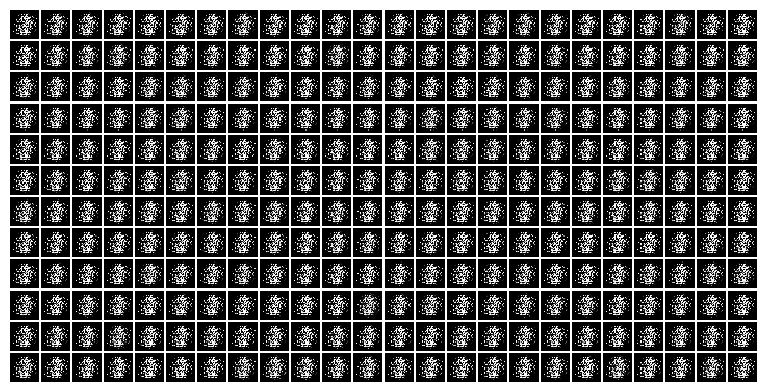

--------------------------------------------------------------------------------
Epoch  20 | G-Loss 9.23 | D-Loss 0.01


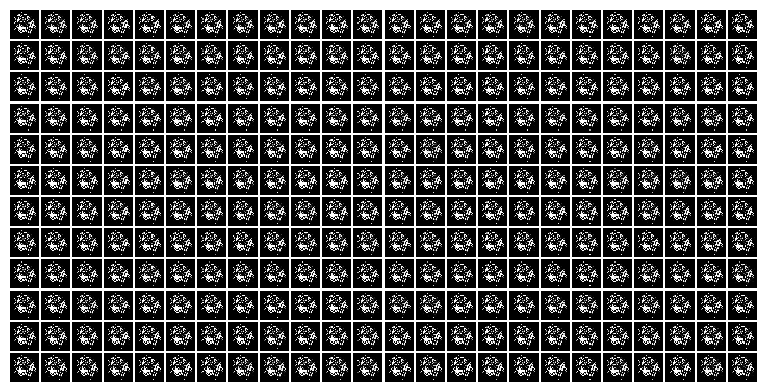

--------------------------------------------------------------------------------


/home/barto/workspace/nn-fundamentals/src/nncore/nn/_layer.py:99: RuntimeWarning: overflow encountered in exp
  self.y = 1.0 / (1.0 + np.exp(-x))


Epoch  40 | G-Loss 2.99 | D-Loss 0.14


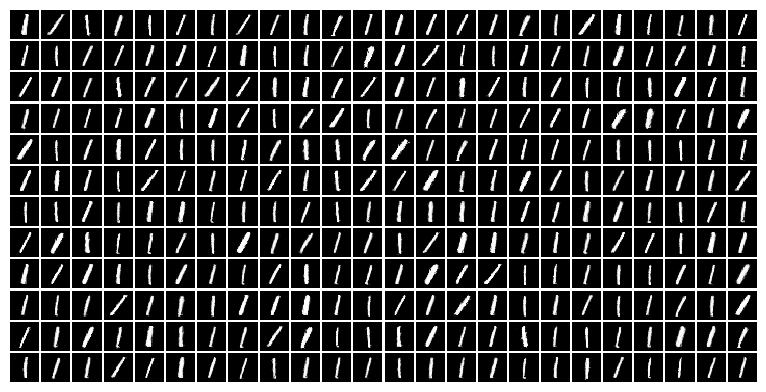

--------------------------------------------------------------------------------
Epoch  60 | G-Loss 2.45 | D-Loss 0.20


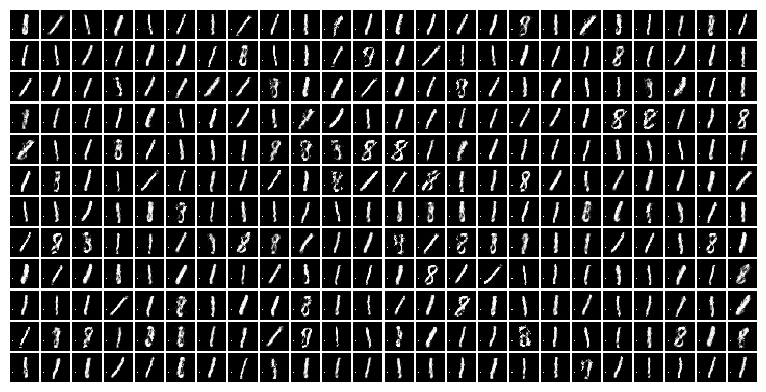

--------------------------------------------------------------------------------
Epoch  80 | G-Loss 2.31 | D-Loss 0.23


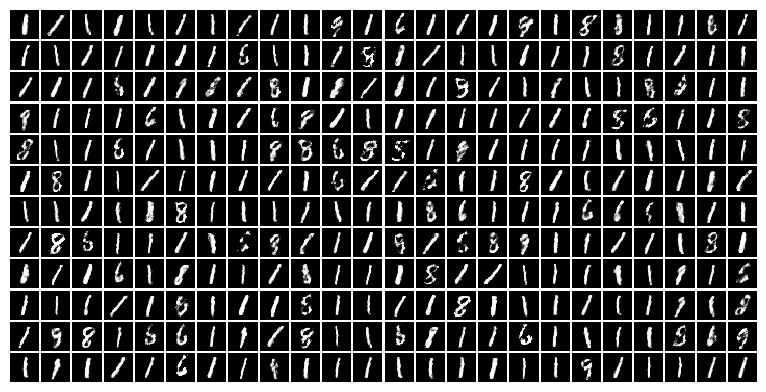

--------------------------------------------------------------------------------
Epoch 100 | G-Loss 2.31 | D-Loss 0.21


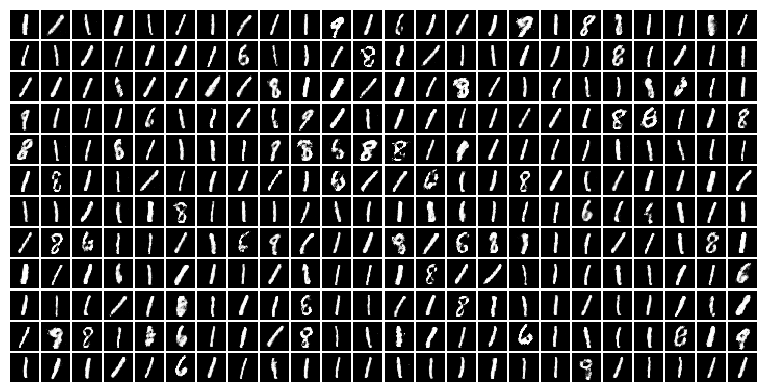

--------------------------------------------------------------------------------
Epoch 120 | G-Loss 2.36 | D-Loss 0.21


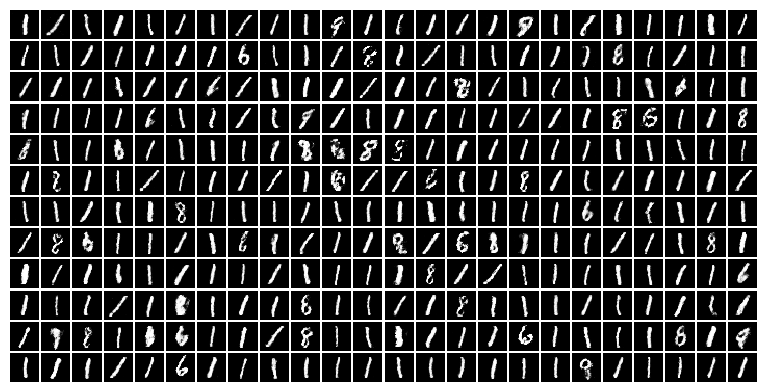

--------------------------------------------------------------------------------
Epoch 140 | G-Loss 2.38 | D-Loss 0.20


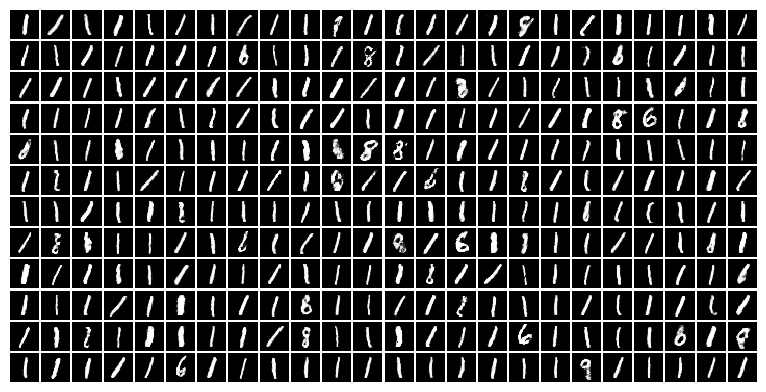

--------------------------------------------------------------------------------
Epoch 160 | G-Loss 2.40 | D-Loss 0.19


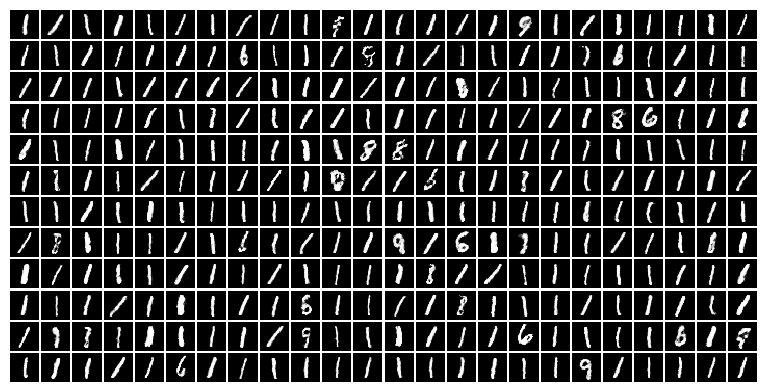

--------------------------------------------------------------------------------
Epoch 180 | G-Loss 2.39 | D-Loss 0.20


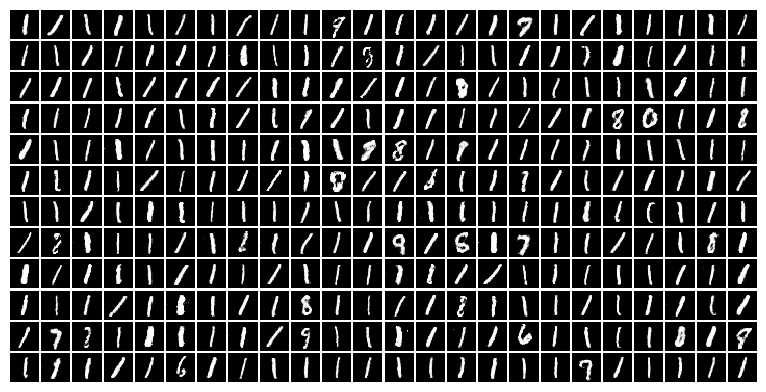

--------------------------------------------------------------------------------
Epoch 200 | G-Loss 2.41 | D-Loss 0.19


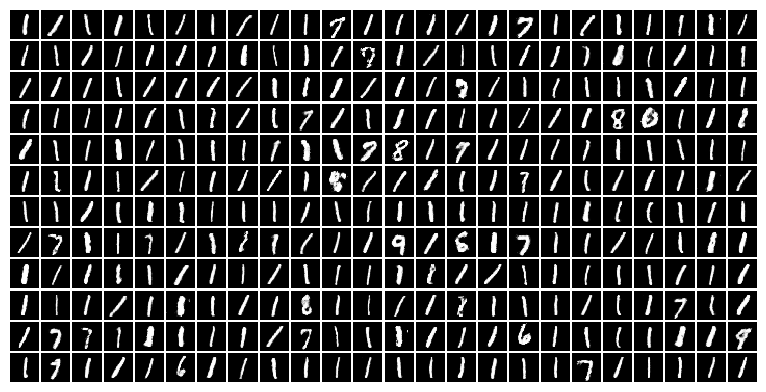

--------------------------------------------------------------------------------


In [7]:
from math import ceil
from tqdm import tqdm

batch_size = 128
log_period = 20
num_epochs = 200

G.reset()
D.reset()

optim_g = optim.Adam(G.parameters(), lr=0.0001, betas=(0.5, 0.999))
optim_d = optim.Adam(D.parameters(), lr=0.0001, betas=(0.5, 0.999))

for epoch in range(num_epochs):
    total = ceil(len(X_train) / batch_size)
    dataloader = chunks(X_train, size=batch_size)

    running_loss_g = 0.0
    running_loss_d = 0.0

    for X_real in dataloader:
        n_samples = X_real.shape[0]

        noise = randn(n_samples, latent_dim)
        X_fake = G.forward(noise, training=True)

        # -------------------
        # Train discriminator
        # -------------------
        X_batch = np.concat((X_real, X_fake))
        t_batch = np.concat((ones(n_samples, 1), zeros(n_samples, 1)))
        y_batch = D.forward(X_batch, training=True)

        loss_d = cross_entropy(t_batch, y_batch)
        grad_y = 1 / len(X_batch) * (sigmoid(y_batch) - t_batch)
        D.backward(grad_y)
        optim_d.apply(D.gradients())

        # ---------------
        # Train generator
        # ---------------
        t_adver = ones(n_samples, 1)
        y_adver = D.forward(X_fake, training=True)

        loss_g = cross_entropy(t_adver, y_adver)
        grad_y = 1 / len(X_fake) * (sigmoid(y_adver) - t_adver)
        G.backward(D.backward(grad_y))
        optim_g.apply(G.gradients())

        # Update running loss
        running_loss_g += loss_g
        running_loss_d += loss_d

    # Log progress
    epoch_loss_g = running_loss_g / total
    epoch_loss_d = running_loss_d / total

    if epoch == 0 or (epoch + 1) % log_period == 0:
        samples = G.forward(fixed_noise, training=False)
        samples = samples.reshape(12, 24, 28, 28)
        print(f"Epoch {epoch+1:>3d} | G-Loss {epoch_loss_g:>2.2f} | D-Loss {epoch_loss_d:>2.2f}")
        tiles(samples)
        print("-" * 80)